In [10]:
from halotools.sim_manager import CachedHaloCatalog, FakeSim
from halotools.empirical_models import PrebuiltHodModelFactory, Zheng07Cens, Zheng07Sats, TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array,wp,tpcf,marked_tpcf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count
import emcee
#import corner
#from Corrfunc.theory.wp import wp
import MCMC_data_file
from numpy.linalg import inv
import scipy.optimize as op
from scipy.stats import chi2
import scipy.stats as stats
import random
import MCMC_data_file, zehavi_data_file_20, guo_data_file, mock_data, mock_data_2
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from scipy.special import gamma
from scipy.stats import chisquare

In [2]:
m = 20

In [3]:
wp_ng_vals = zehavi_data_file_20.get_wp()
bin_edges = zehavi_data_file_20.get_bins()
cov_matrix = zehavi_data_file_20.get_cov()
err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

2000000


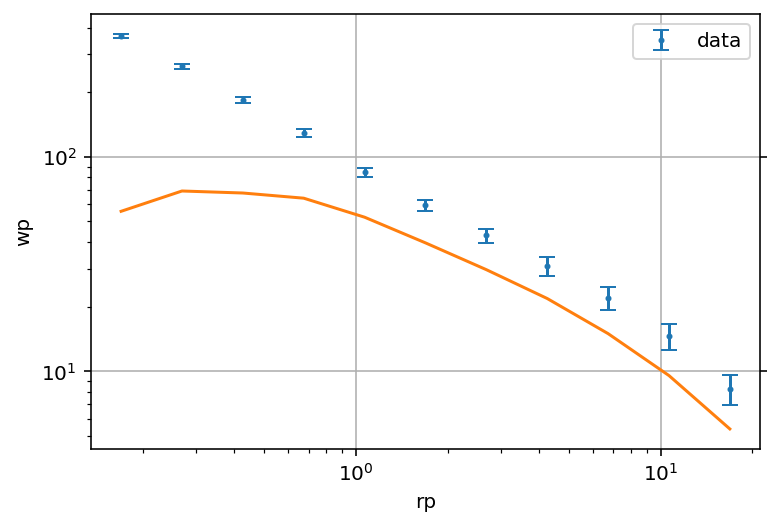

In [13]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')

#cens_occ_model = Zheng07Cens(prim_haloprop_key = 'halo_vmax')
cens_occ_model = Zheng07Cens(threshold = -m)
cens_prof_model = TrivialPhaseSpace(threshold = -m)

#sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'halo_vmax', modulate_with_cenocc=True)
sats_occ_model =  Zheng07Sats(modulate_with_cenocc=True,threshold = -m)
sats_prof_model = NFWPhaseSpace(threshold = -m)

#halocat = CachedHaloCatalog(simname='bolshoi',redshift = 0.0)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_1.00231.list.halotools_v0p4.hdf5',update_cached_fname = True)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/Downloads/hlist_1.00231.list.halotools_v0p1.hdf5',update_cached_fname = True)
halocat = CachedHaloCatalog(fname='/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/2019-07-03-18-38-02-9731.dat.my_cosmosim_halos.hdf5')
halocat.redshift = 0.
pi_max = 60.
Lbox = 400.
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)


param_sampling = [11.96,0.38,1.16,13.28-1.7,13.28]
model_instance.param_dict['logMmin'] = param_sampling[0]#Mmin_val[i]
model_instance.param_dict['sigma_logM'] = param_sampling[1]#sigma_val[i]
model_instance.param_dict['alpha'] = param_sampling[2]#alpha_val[i]
model_instance.param_dict['logM0'] = param_sampling[3]#M0_val[i]
model_instance.param_dict['logM1'] = param_sampling[4]#M1_val[i]

try:
    model_instance.mock.populate()
except:
    model_instance.populate_mock(halocat)
"""        
gpos = return_xyz_formatted_array(model_instance.mock.galaxy_table['x'], model_instance.mock.galaxy_table['y'],
                                 model_instance.mock.galaxy_table['z'],period = Lbox)

x = gpos[:,0]
y = gpos[:,1]
z = gpos[:,2]
velz = model_instance.mock.galaxy_table['vz']
pos_zdist = return_xyz_formatted_array(x,y,z, period = Lbox, velocity=velz, velocity_distortion_dimension='z')
gmod = wp(Lbox,pi_max,4,bin_edges,x,y,z,verbose=True)
plt.plot(bin_cen,gmod['wp'],markersize=2)
"""

#halo_table = model_instance.mock.halo_table
halo_table = halocat.halo_table
mask = np.where(halo_table['halo_mvir_host_halo']>2e12)

mass_cut_ht = halo_table[halo_table['halo_mvir_host_halo']>2e12]

hpos = return_xyz_formatted_array(mass_cut_ht['halo_x'], mass_cut_ht['halo_y'],
                                 mass_cut_ht['halo_z'],period = Lbox)
x = hpos[:,0]
y = hpos[:,1]
z = hpos[:,2]
#pos = np.vstack((x,y,z)).T
velz = mass_cut_ht['halo_vz']

pos_zdist = return_xyz_formatted_array(x,y,z,period=Lbox,
                velocity=velz,velocity_distortion_dimension='z')

#hmod = wp(Lbox,pi_max,4,bin_edges,pos_zdist[:,0],pos_zdist[:,1],pos_zdist[:,2],verbose=True)

mod = wp(pos_zdist, bin_edges, pi_max, period=Lbox)
#mod = wp(pos, bin_edges,pi_max,period=Lbox)

plt.plot(bin_cen,mod,markersize=2)#,label='Vmax')
plt.legend()
plt.ylabel('wp')
plt.xlabel('rp')
plt.tick_params(right=True)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

In [15]:
mass_cut_ht = halo_table[halo_table['halo_mvir_host_halo']>5e11]
print(len(mass_cut_ht))

500208
